[A_Quiet_Place_Day1] extracted 196 frames
[Alien_Romulus] extracted 125 frames
[BEETLEJUICE_BEETLEJUICE] extracted 152 frames
[BLINK_TWICE] extracted 322 frames
[Borderlands] extracted 346 frames
[CUCKOO] extracted 288 frames
[Deadpool_Wolverine] extracted 318 frames
[Despicable_Me_4] extracted 292 frames
[Fly_Me_To_The_Moon] extracted 289 frames
[GLADIATOR_2 NEEDS EDIT] extracted 180 frames
[GLADIATOR_2] extracted 159 frames
[HAROLD_PURPLE_CRAYON NEEDS EDIT] extracted 259 frames
[HAROLD_PURPLE_CRAYON] extracted 245 frames
[Inside_Out_2] extracted 289 frames
[Joker_Folie_Deux] extracted 288 frames
[KRAVEN_HUNTER NEEDS EDIT] extracted 378 frames
[KRAVEN_HUNTER] extracted 364 frames
[LEE] extracted 136 frames
[Longlegs] extracted 170 frames
[MOANA_2 NEEDS EDIT] extracted 183 frames
[MOANA_2] extracted 153 frames
[SONIC_3 NEEDS EDIT] extracted 210 frames
[SONIC_3] extracted 188 frames
[Speak_No_Evil] extracted 350 frames
[TWISTERS] extracted 239 frames
[The_Crow] extracted 359 frames
[The

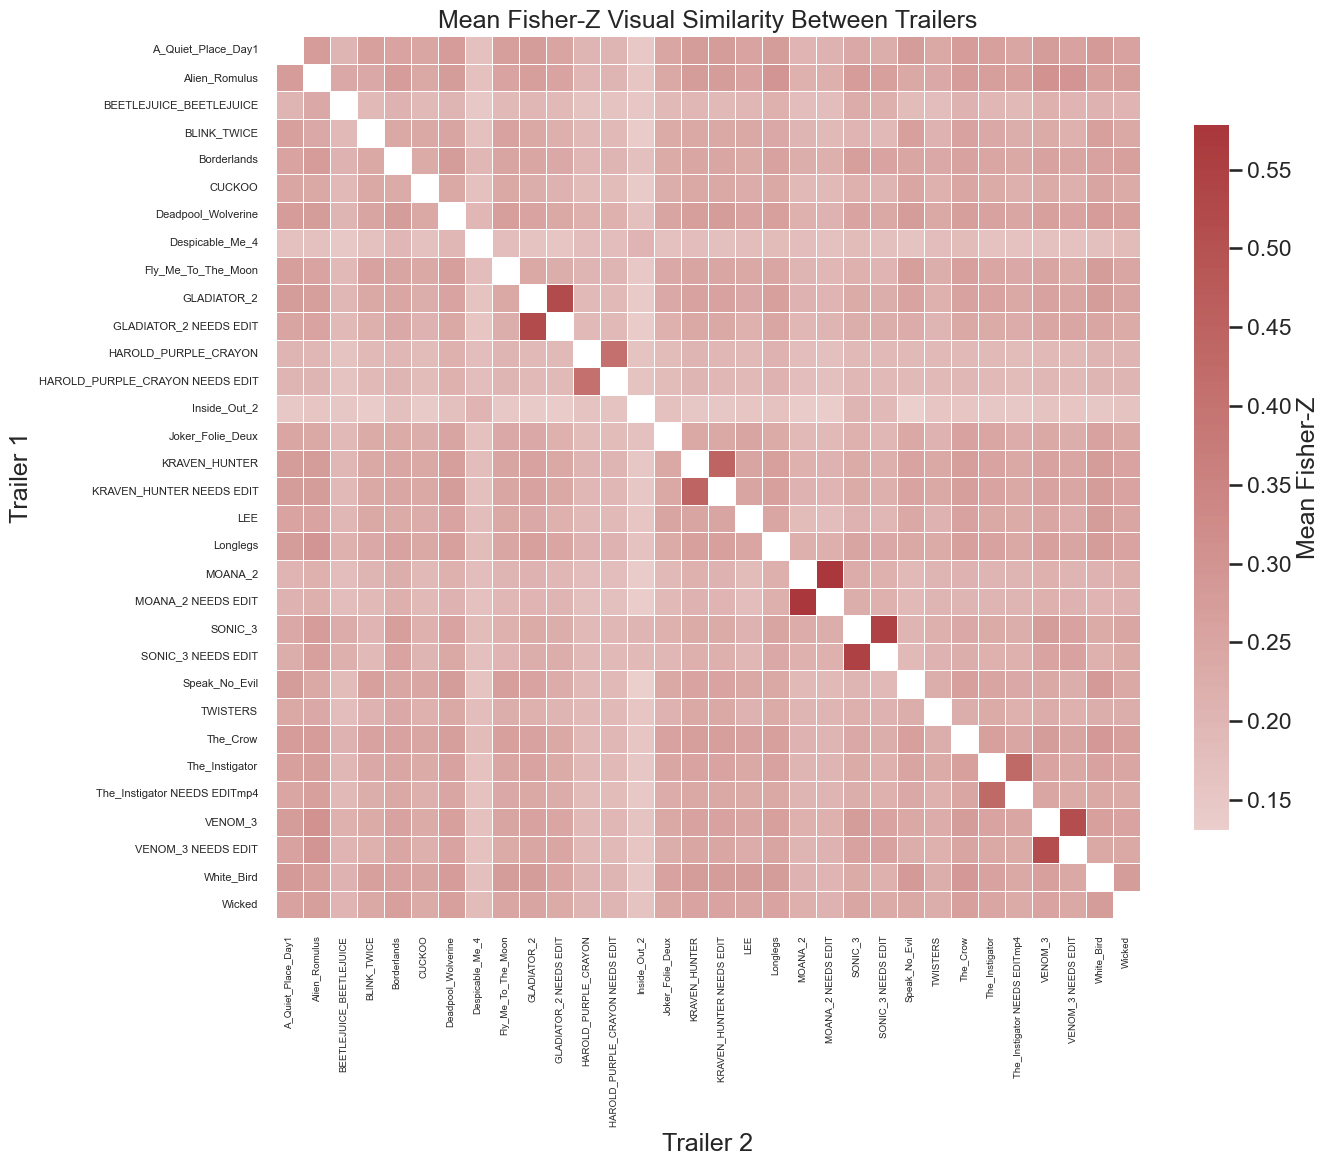

                                 hist_entropy  face_pct  body_pct  motion_dyn  \
A_Quiet_Place_Day1                   2.063156  0.081633  0.571429    0.101390   
Alien_Romulus                        0.795855  0.000000  0.523810    0.048621   
BEETLEJUICE_BEETLEJUICE              2.677902  0.184211  0.473684    0.142003   
BLINK_TWICE                          2.908902  0.465839  0.819876    0.145736   
Borderlands                          3.049848  0.242775  0.566474    0.152112   
CUCKOO                               2.519865  0.201389  0.604167    0.111658   
Deadpool_Wolverine                   2.695057  0.245283  0.710692    0.132729   
Despicable_Me_4                      4.545397  0.061644  0.575342    0.186376   
Fly_Me_To_The_Moon                   2.917523  0.406897  0.758621    0.156725   
GLADIATOR_2                          1.443275  0.125000  0.412500    0.090936   
GLADIATOR_2 NEEDS EDIT               1.503495  0.100000  0.411111    0.088605   
HAROLD_PURPLE_CRAYON        

In [1]:
import os
import glob
import cv2
import dlib
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings("ignore")
sns.set(style='white', context='talk')

TRAILER_ROOT  = os.path.expanduser("~/Downloads/trailers")
VISUAL_OUT    = os.path.expanduser("~/derivatives/visual_HOG")
VISUAL_DIR = os.path.join(VISUAL_OUT, "CSV")
FRAME_DIR     = os.path.join(VISUAL_OUT, "frames")

os.makedirs(FRAME_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

chunk_dur = 0.48
window_secs = 15
step_secs   = 5
WINSZ       = int(window_secs / chunk_dur)
STEP        = int(step_secs   / chunk_dur)
BATCH_SIZE  = 16
N_JOBS      = 12
skip_rate   = 2
downscale   = (640, 480)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_detector = dlib.get_frontal_face_detector()
hog_person    = cv2.HOGDescriptor()
hog_person.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

def extract_048fps quiet place: 0.36fps(video_path, out_dir):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 24
    skip = max(1, int(round(fps * chunk_dur)))
    seg = os.path.basename(video_path).rsplit('.', 1)[0]
    seg_dir = os.path.join(out_dir, seg)
    os.makedirs(seg_dir, exist_ok=True)
    idx = saved = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % skip == 0:
            cv2.imwrite(os.path.join(seg_dir, f"{seg}_frame_{idx}.jpg"), frame)
            saved += 1
        idx += 1
    cap.release()
    print(f"[{seg}] extracted {saved} frames")

video_paths = [
    os.path.join(TRAILER_ROOT, f)
    for f in sorted(os.listdir(TRAILER_ROOT))
    if f.lower().endswith('.mp4')
]
for vp in video_paths:
    extract_048fps(vp, FRAME_DIR)

fe = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=fe.image_mean, std=fe.image_std)
])

class FrameDataset(Dataset):
    def __init__(self, paths):
        self.paths = sorted(paths)
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, i):
        return transform(Image.open(self.paths[i]).convert("RGB"))

def process_segment(seg):
    seg_dir = os.path.join(FRAME_DIR, seg)
    jpgs = glob.glob(os.path.join(seg_dir, f"{seg}_frame_*.jpg"))
    if not jpgs:
        print(f"[{seg}] no frames")
        return seg, None
    dl = DataLoader(FrameDataset(jpgs), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    feats = []
    for batch in dl:
        batch = batch.to(device)
        with torch.no_grad():
            out = model(batch).last_hidden_state.mean(dim=1).cpu().numpy()
        feats.append(out)
    feats = np.vstack(feats)
    np.save(os.path.join(VISUAL_DIR, f"{seg}_sampled_480ms_features.npy"), feats)
    print(f"[{seg}] saved {feats.shape}")
    return seg, feats.shape

segments = [os.path.basename(p).rsplit('.',1)[0] for p in video_paths]
Parallel(n_jobs=N_JOBS, backend="threading")(
    delayed(process_segment)(seg) for seg in segments
)

def apply_moving_average(feats, target_dim=128):
    groups = feats.shape[1] // target_dim
    return feats.reshape(feats.shape[0], target_dim, groups).mean(axis=2)

for seg in segments:
    arr = np.load(os.path.join(VISUAL_DIR, f"{seg}_sampled_480ms_features.npy"))
    red = apply_moving_average(arr)
    np.save(os.path.join(VISUAL_DIR, f"{seg}_reduced_moving_avg_features.npy"), red)

visual = {
    seg: np.load(os.path.join(VISUAL_DIR, f"{seg}_reduced_moving_avg_features.npy"))
    for seg in segments
}

records = []
for i, s1 in enumerate(segments):
    A, n1 = visual[s1], visual[s1].shape[0]
    for s2 in segments[i+1:]:
        B, n2 = visual[s2], visual[s2].shape[0]
        for t0 in range(0, n1-WINSZ+1, STEP):
            win1 = A[t0:t0+WINSZ].ravel().reshape(1,-1)
            for u0 in range(0, n2-WINSZ+1, STEP):
                win2 = B[u0:u0+WINSZ].ravel().reshape(1,-1)
                r = cosine_similarity(win1, win2)[0,0]
                z = np.arctanh(np.clip(r, -0.999999, 0.999999))
                records.append({
                    'vid1': s1, 'vid2': s2,
                    'v1_start_s': round(t0*chunk_dur,2),
                    'v2_start_s': round(u0*chunk_dur,2),
                    'sim_z': z
                })
df_slide = pd.DataFrame(records)
df_slide.to_csv(os.path.join(VISUAL_DIR, "visual_pair_similarity.csv"), index=False)

mean_df = df_slide.groupby(["vid1","vid2"])["sim_z"].mean().reset_index()
rev     = mean_df.rename(columns={"vid1":"vid2","vid2":"vid1"})
full    = pd.concat([mean_df, rev], ignore_index=True)
mat     = full.pivot(index="vid1", columns="vid2", values="sim_z")

fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(mat, cmap="vlag", center=0, linewidths=0.5, ax=ax,
            cbar_kws={'shrink':0.8, 'label':'Mean Fisher-Z'})
ax.set_xticklabels(mat.columns, rotation=90, fontsize=7, ha='center')
ax.set_yticklabels(mat.index, rotation=0, fontsize=8)
ax.set_xlabel("Trailer 2")
ax.set_ylabel("Trailer 1")
ax.set_title("Mean Fisher-Z Visual Similarity Between Trailers")
plt.tight_layout()
plt.show()

def process_video_folder(seg):
    face_det = dlib.get_frontal_face_detector()
    hog_per  = cv2.HOGDescriptor()
    hog_per.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    seg_dir = os.path.join(FRAME_DIR, seg)
    files   = sorted(f for f in os.listdir(seg_dir) if f.endswith('.jpg'))
    hist_vals, face_cnt, body_cnt, motions = [], 0, 0, []
    prev_gray, sample_count = None, 0

    for idx, fname in enumerate(files):
        img = cv2.imread(os.path.join(seg_dir, fname))
        if img is None:
            continue
        hist = cv2.calcHist([img],[0,1,2],None,(8,8,8),[0,256]*3).flatten()
        p    = hist/hist.sum() if hist.sum()>0 else np.ones_like(hist)/hist.size
        hist_vals.append(entropy(np.where(p==0,1e-12,p), base=2))

        if idx % skip_rate == 0:
            sample_count += 1

            small = cv2.resize(img, (960, 540))  
            gray  = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
            dets = face_det(gray, 2)
            if len(dets) > 0:
                face_cnt += 1

            rects, _ = hog_per.detectMultiScale(
                small, winStride=(8,8), padding=(8,8), scale=1.05
            )
            if len(rects) > 0:
                body_cnt += 1

            if prev_gray is not None:
                diff = cv2.absdiff(gray, prev_gray).astype(np.float32)/255.0
                motions.append(diff.mean())
            prev_gray = gray
    arr = visual.get(seg, None)
    tv_var = float(np.var(arr,axis=0).mean()) if arr is not None else 0
    pace   = float(np.linalg.norm(np.diff(arr,axis=0),axis=1).mean()) if arr is not None else 0

    return {
        'hist_entropy':      np.mean(hist_vals)           if hist_vals    else 0,
        'face_pct':          face_cnt  / sample_count    if sample_count else 0,
        'body_pct':          body_cnt  / sample_count    if sample_count else 0,
        'motion_dyn':        np.mean(motions)            if motions      else 0,
        'temporal_variance': tv_var,
        'editing_pace':      pace
    }
segments = sorted([d for d in os.listdir(FRAME_DIR) if os.path.isdir(os.path.join(FRAME_DIR,d))])
stats = Parallel(n_jobs=N_JOBS, backend="threading")(
    delayed(process_video_folder)(seg) for seg in segments
)
df_stats = pd.DataFrame(stats, index=segments)
df_stats.to_csv(os.path.join(VISUAL_DIR, 'visuals_extra.csv'))
print(df_stats)

